# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt

# Import FEYN

In [2]:
import feyn
ql = feyn.QLattice(random_seed=333)

This version of feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at `https://abzu.ai/eula`.


# Import data

In [3]:
path = 'CRC/'
df = pd.read_csv(path + "/all_data.csv")

In [4]:
lbl=LabelEncoder()
df['condition'] = lbl.fit_transform(df['condition'])

In [5]:
groups = df["Country"].to_numpy()
X = df.drop(["Unnamed: 0", "Country"], axis=1)
y = df["condition"].to_numpy()

In [6]:
X

,condition,Streptococcus_anginosus___ref_mOTU_v2_0004__,Enterobacteriaceae_sp.___ref_mOTU_v2_0036__,Citrobacter_sp.___ref_mOTU_v2_0076__,Klebsiella_michiganensis/oxytoca___ref_mOTU_v2_0079__,Enterococcus_faecalis___ref_mOTU_v2_0116__,Lactobacillus_salivarius___ref_mOTU_v2_0125__,Dielma_fastidiosa___ref_mOTU_v2_0138__,Streptococcus_constellatus/intermedius___ref_mOTU_v2_0143__,Streptococcus_parasanguinis___ref_mOTU_v2_0144__,...,unknown_Porphyromonas___meta_mOTU_v2_7777__,unknown_Clostridiales___meta_mOTU_v2_7778__,unknown_Clostridiales___meta_mOTU_v2_7781__,unknown_Clostridiales___meta_mOTU_v2_7782__,unknown_Clostridiales___meta_mOTU_v2_7784__,Clostridium_sp._CAG__230___meta_mOTU_v2_7788__,Clostridium_sp._CAG__1193___meta_mOTU_v2_7789__,unknown_Erysipelotrichaceae___meta_mOTU_v2_7790__,unknown_Clostridiales___meta_mOTU_v2_7795__,unknown_Clostridiales___meta_mOTU_v2_7800__
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000083,0.000000,0.000249,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000083,0.000083
1,1,0.000591,0.000066,0.000000,0.000000,0.000000,0.000000,0.000000,0.000066,0.002102,...,0.000000,0.000000,0.000000,0.000788,0.000000,0.000000,0.0,0.0,0.000000,0.000000
2,1,0.000840,0.000065,0.002454,0.000000,0.000065,0.013111,0.000000,0.000065,0.012013,...,0.000000,0.000000,0.000194,0.000065,0.000000,0.000840,0.0,0.0,0.001808,0.000000
3,1,0.000000,0.000071,0.000000,0.000000,0.000000,0.000000,0.000213,0.000071,0.000142,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
4,1,0.000086,0.019236,0.001111,0.000256,0.000086,0.000086,0.000000,0.000000,0.000513,...,0.000000,0.000171,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0,0.000000,0.000118,0.000000,0.000000,0.000059,0.000000,0.000118,0.000000,0.000059,...,0.002590,0.000000,0.000000,0.001118,0.000000,0.000000,0.0,0.0,0.000000,0.000000
764,0,0.000038,0.000038,0.000000,0.000000,0.000000,0.000000,0.000075,0.000038,0.000113,...,0.000151,0.000000,0.000000,0.000151,0.000038,0.000000,0.0,0.0,0.000000,0.000000
765,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000348,0.000044,0.001741,0.000000,0.000435,0.0,0.0,0.000000,0.000044
766,0,0.000000,0.000312,0.000000,0.000000,0.000208,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000208,0.000000,0.0,0.0,0.000000,0.000156


## Dataset names

In [7]:
unique_groups = list(np.unique(groups))
unique_groups

['AT-CRC_species',
 'CN-CRC_species',
 'DE-CRC_species',
 'FR-CRC_species',
 'IT-CRC-2_species',
 'IT-CRC_species',
 'JP-CRC_species',
 'US-CRC_species']

# Creating dataframes for results

In [8]:
AUC_scores = pd.DataFrame(index=unique_groups, columns=unique_groups)

In [9]:
ROC_curve = pd.DataFrame(index=unique_groups, columns=["fpr","tpr","auc"])

# LOSO validation with random forests

In [10]:
show_fold_stats = True

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Group : 8 US-CRC_species
ROC AUC score for RandomForest model, LOGO test set: 0.6953
None
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


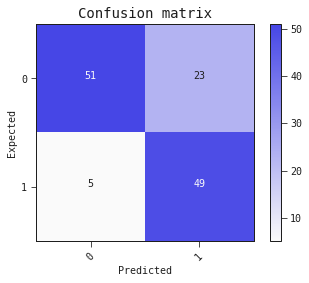

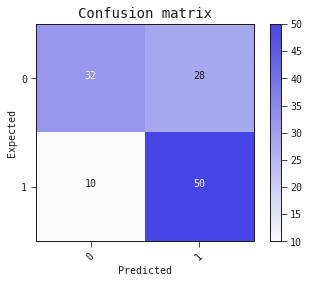

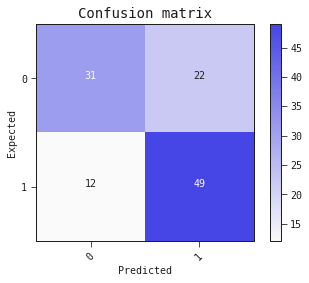

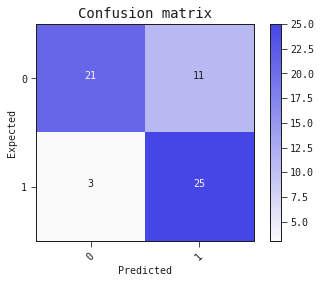

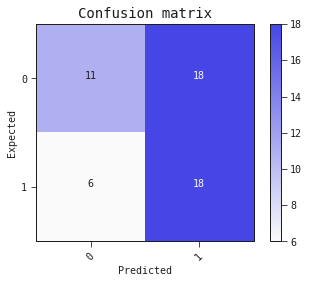

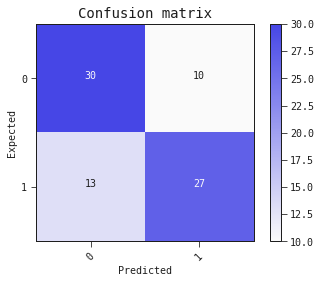

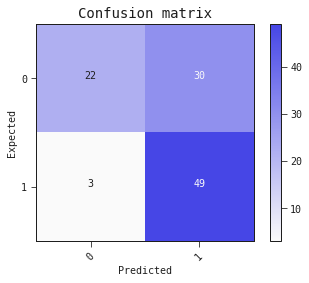

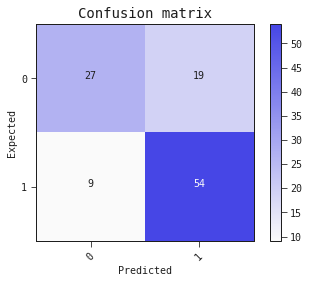

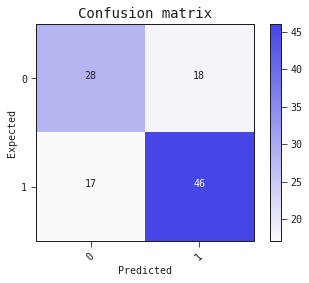

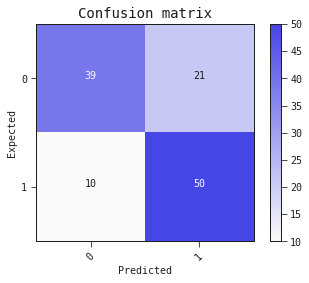

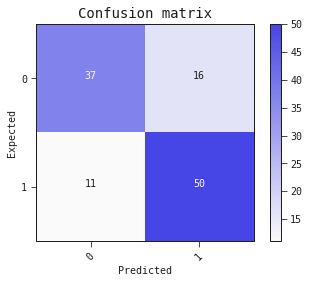

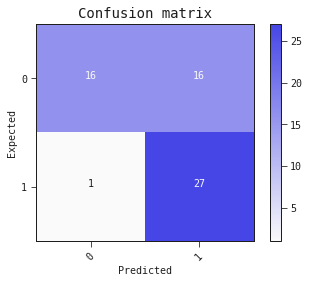

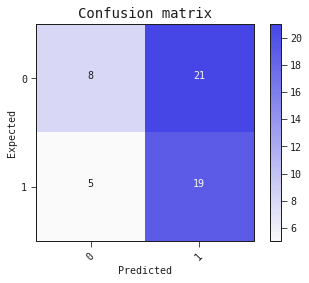

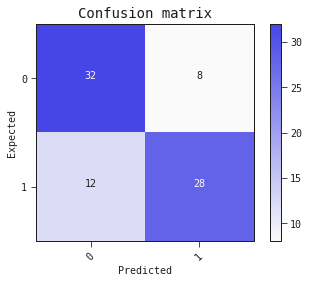

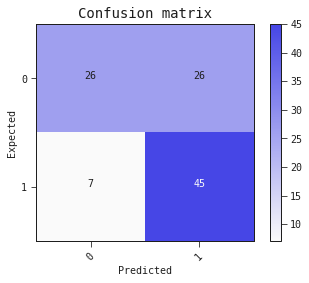

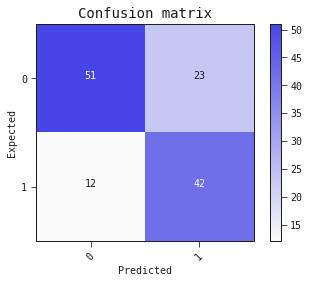

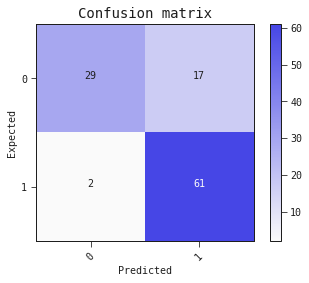

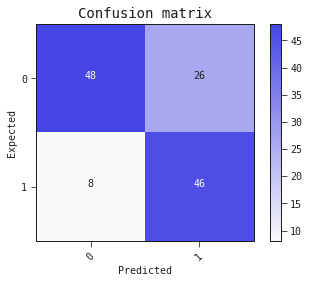

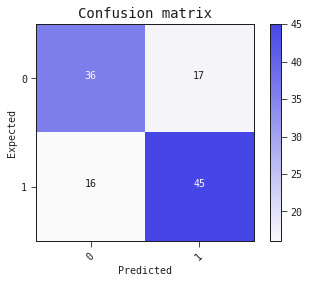

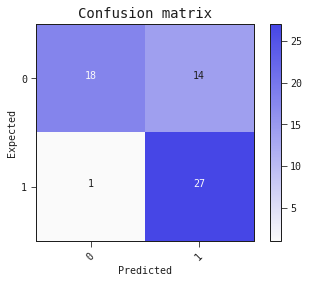

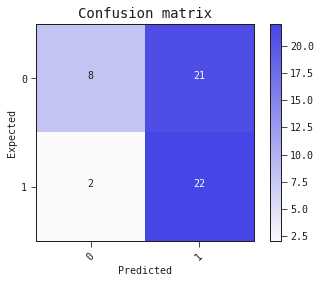

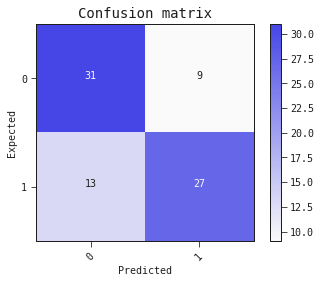

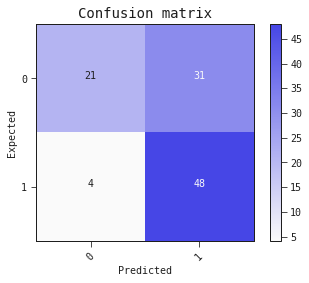

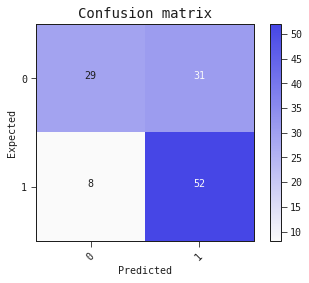

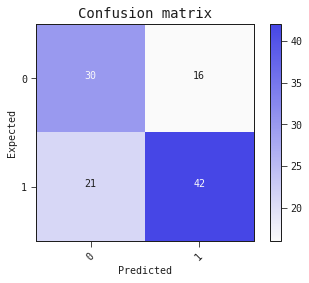

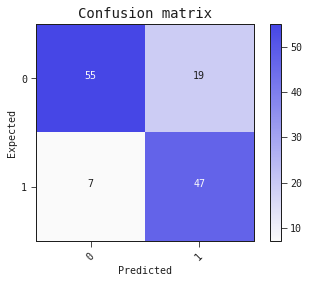

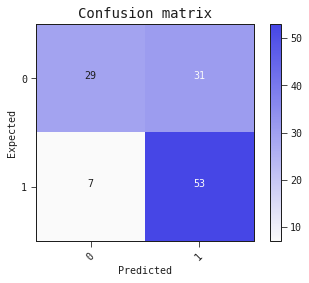

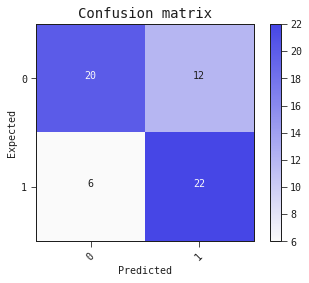

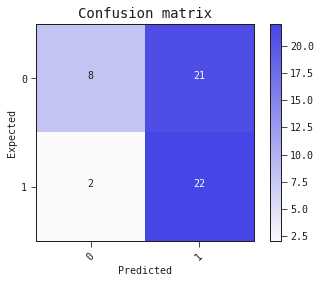

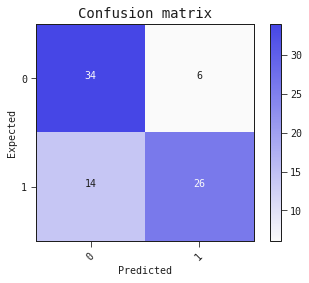

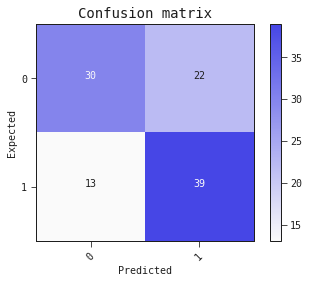

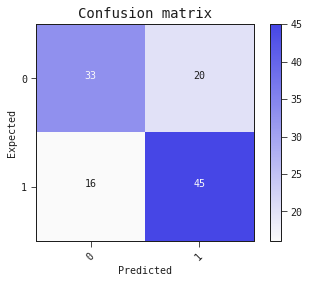

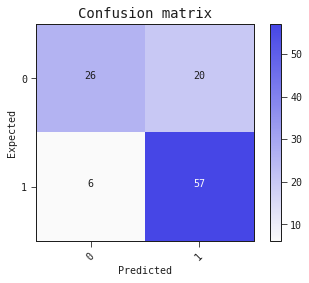

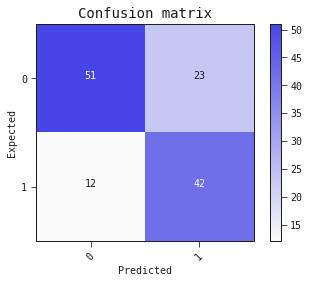

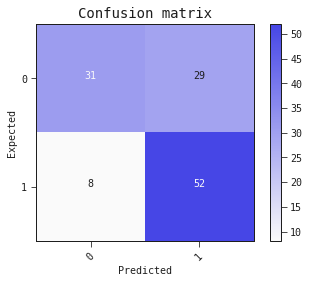

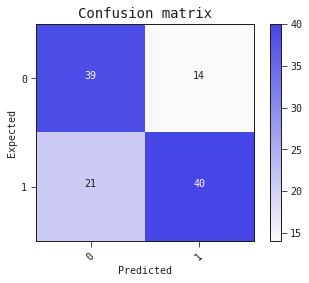

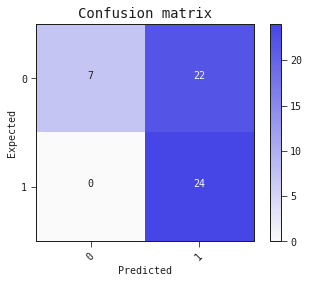

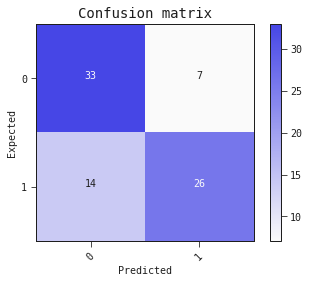

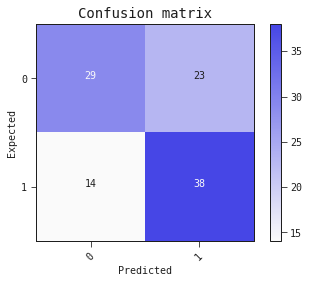

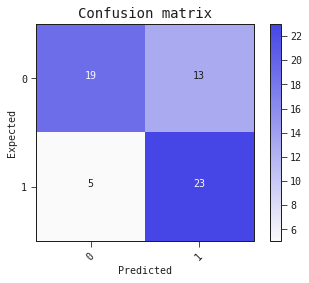

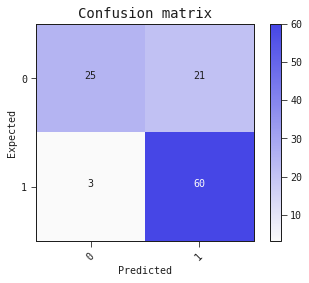

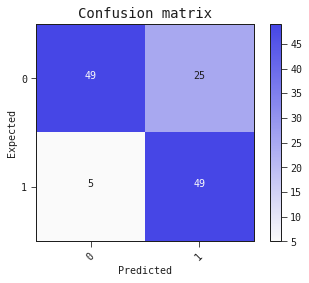

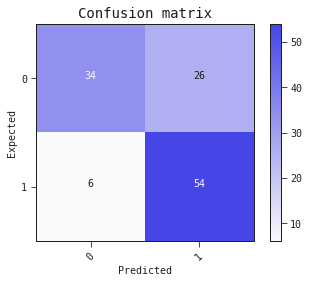

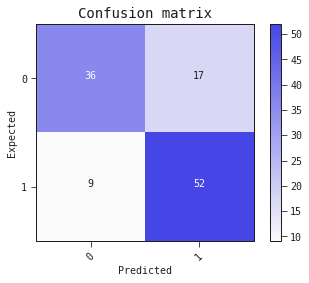

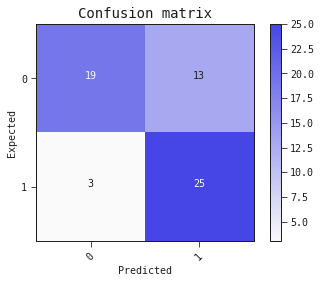

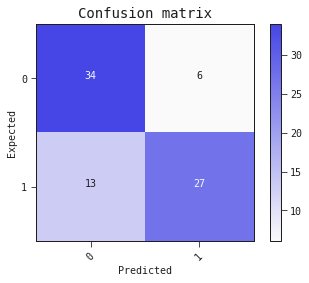

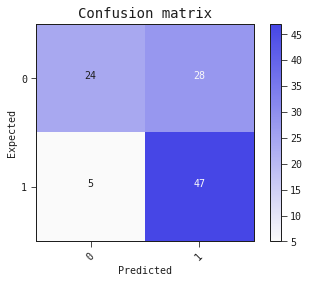

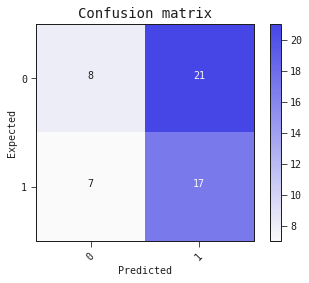

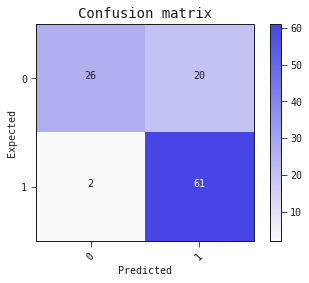

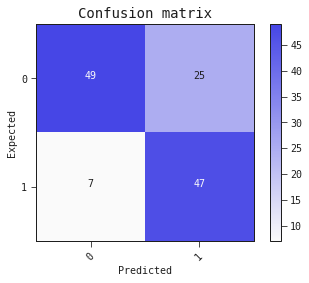

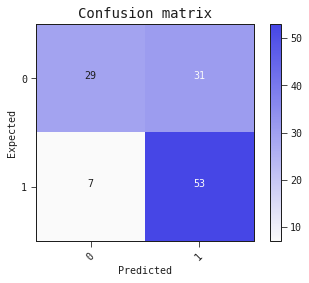

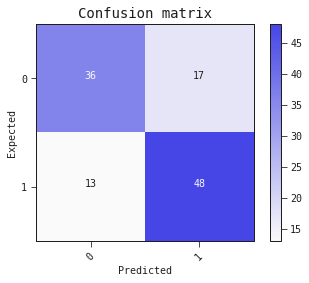

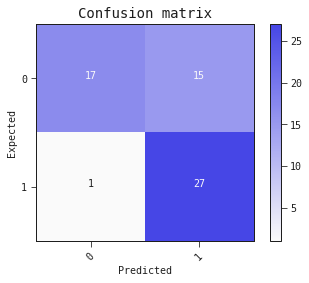

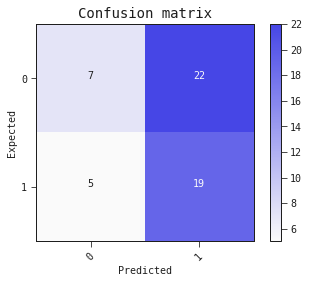

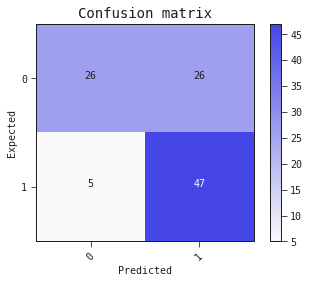

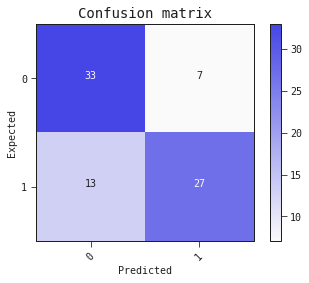

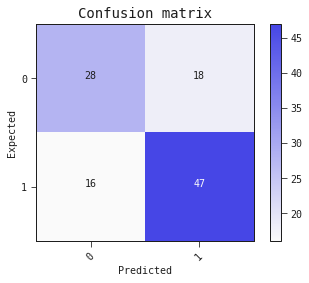

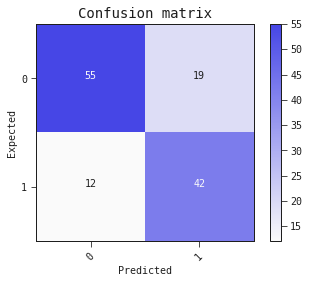

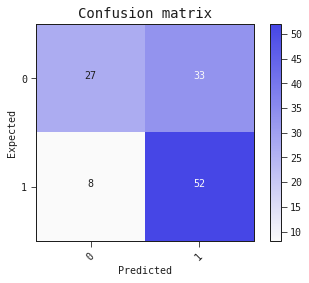

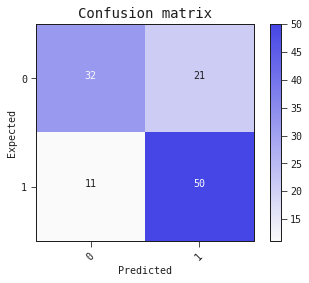

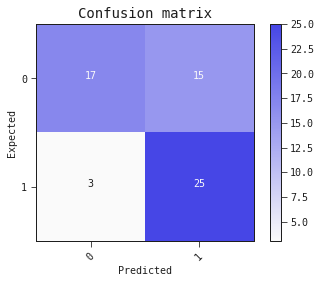

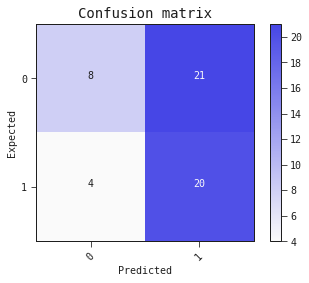

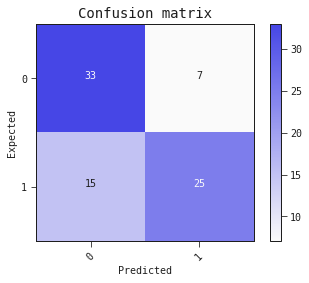

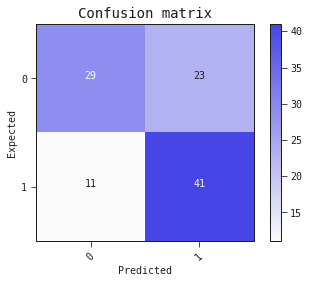

In [11]:
grp = 0
for i in range(len(unique_groups)):
    outer_test_index = list(np.where(df["Country"]==unique_groups[i])[0])
    
    inner_group_list = []
    inner_group_list.append(unique_groups[:i] + unique_groups[i+1:])
    
    outer_train_index = list(np.where(df["Country"]!=unique_groups[i])[0])
    
    #Training dataset
    outer_train_X = X.iloc[outer_train_index]
    outer_train_y = y[outer_train_index]
    
    #Test dataset
    outer_test_X =  X.iloc[outer_test_index]
    outer_test_y =  y[outer_test_index]
    
    for k,name in enumerate(inner_group_list[0]):
        inner_val_index = list(np.where(df["Country"]==name)[0])
        
        inner_train_names = []
        inner_train_names.append(inner_group_list[:k] + inner_group_list[k+1:])
        
        inner_train_index = list(np.where((df["Country"]!=name) & (df["Country"]!=unique_groups[i]))[0])
    
        #Inner training dataset
        inner_train_X = X.iloc[inner_train_index]
        inner_train_y = y[inner_train_index]
        
        #Inner validation dataset
        inner_val_X =  X.iloc[inner_val_index]
        inner_val_y =  y[inner_val_index]
                
        
        # Feyn
        models = ql.auto_run(inner_train_X, output_name = 'condition', kind = 'classification', n_epochs=10)
        best = models[0]
        
        y_pred = best.predict(inner_val_X)

        RF_AUC_test_score = best.roc_auc_score(inner_val_X)

        #Adding auc to dataframe
        AUC_scores.at[unique_groups[i], name] = RF_AUC_test_score

        if show_fold_stats:
            print('-' * 80)
            print('Fold : %s'%(k+1),name)
            print('ROC AUC score for RandomForest model, validation set: %.4f'%RF_AUC_test_score)
            print(best.plot_confusion_matrix(inner_val_X))
            
    
    #Feyn on logo_test data
    models = ql.auto_run(outer_train_X, output_name = 'condition', kind = 'classification', n_epochs=50)
    best = models[0]
    
    y_pred = best.predict(outer_test_X)

    RF_AUC_test_score = best.roc_auc_score(outer_test_X)

    #Adding auc to dataframe
    AUC_scores.at[unique_groups[i], unique_groups[i]] = RF_AUC_test_score
    
    #Getting AUCROC data
    fpr, tpr, _ = roc_curve(outer_test_y,  y_pred)

    #Adding roc curve values to dataframe
    ROC_curve.at[unique_groups[i], "fpr"] = ",".join(str(x) for x in fpr)
    ROC_curve.at[unique_groups[i], "tpr"] = ",".join(str(x) for x in tpr)
    ROC_curve.at[unique_groups[i], "auc"] = RF_AUC_test_score
    

    if show_fold_stats:
        print('-' * 80)
        print('-' * 80)
        print('Group : %s'%(grp+1),unique_groups[i])
        print('ROC AUC score for RandomForest model, LOGO test set: %.4f'%RF_AUC_test_score)
        print(best)
        print(best.plot_confusion_matrix(outer_test_X))
        print('-' * 80)
        print('-' * 80)
        grp += 1
        

# Results and plots

In [12]:
AUC_scores

,AT-CRC_species,CN-CRC_species,DE-CRC_species,FR-CRC_species,IT-CRC-2_species,IT-CRC_species,JP-CRC_species,US-CRC_species
AT-CRC_species,0.81677,0.818193,0.798611,0.697804,0.768973,0.672414,0.790938,0.64608
CN-CRC_species,0.789165,0.78003,0.778889,0.792453,0.74442,0.611351,0.797187,0.655325
DE-CRC_species,0.896308,0.80005,0.767917,0.774204,0.826451,0.649425,0.799375,0.697855
FR-CRC_species,0.802622,0.87037,0.791806,0.723631,0.783482,0.649425,0.823125,0.695266
IT-CRC-2_species,0.892857,0.773023,0.780556,0.783174,0.710938,0.630747,0.771875,0.705806
IT-CRC_species,0.908213,0.80518,0.828056,0.816888,0.737723,0.609195,0.797187,0.715237
JP-CRC_species,0.889924,0.809935,0.767083,0.803897,0.80692,0.577586,0.780625,0.686021
US-CRC_species,0.796756,0.811311,0.75875,0.721466,0.734933,0.62069,0.75375,0.695266


In [13]:
AUC_scores = AUC_scores.apply(pd.to_numeric, errors='coerce')

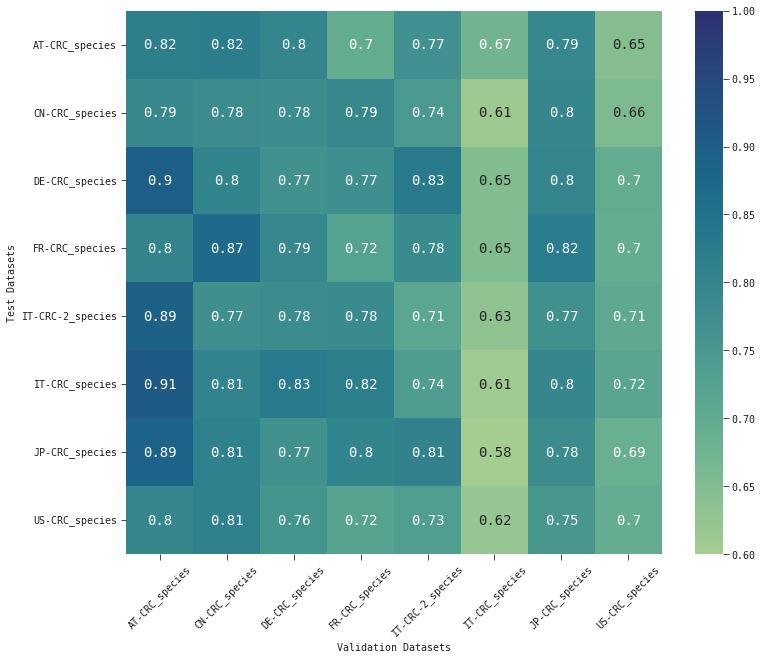

In [14]:
plt.figure(figsize=(12,10))
sns.set_palette("husl", 8)
ax = sns.heatmap(AUC_scores, annot = True, cmap="crest", vmin=0.6, vmax=1.0, annot_kws={"fontsize":14})
ax.set(xlabel="Validation Datasets", ylabel="Test Datasets")
ax.tick_params(axis='x', rotation=45)
plt.savefig("plots/LOSO_FEYN_1.jpg")
plt.show()

# ROC curves

In [15]:
ROC_curve

,fpr,tpr,auc
AT-CRC_species,"0.0,0.0,0.0,0.021739130434782608,0.02173913043...","0.0,0.031746031746031744,0.09523809523809523,0...",0.81677
CN-CRC_species,"0.0,0.13513513513513514,0.14864864864864866,0....","0.0,0.18518518518518517,0.18518518518518517,0....",0.78003
DE-CRC_species,"0.0,0.08333333333333333,0.11666666666666667,0....","0.0,0.38333333333333336,0.38333333333333336,0....",0.767917
FR-CRC_species,"0.0,0.0,0.018867924528301886,0.018867924528301...","0.0,0.01639344262295082,0.01639344262295082,0....",0.723631
IT-CRC-2_species,"0.0,0.25,0.25,0.28125,0.28125,0.34375,0.34375,...","0.0,0.4642857142857143,0.5357142857142857,0.53...",0.710938
IT-CRC_species,"0.0,0.06896551724137931,0.06896551724137931,0....","0.0,0.0,0.08333333333333333,0.0833333333333333...",0.609195
JP-CRC_species,"0.0,0.05,0.05,0.075,0.075,0.1,0.1,0.15,0.15,0....","0.0,0.1,0.325,0.325,0.475,0.475,0.55,0.55,0.65...",0.780625
US-CRC_species,"0.0,0.019230769230769232,0.057692307692307696,...","0.0,0.07692307692307693,0.07692307692307693,0....",0.695266


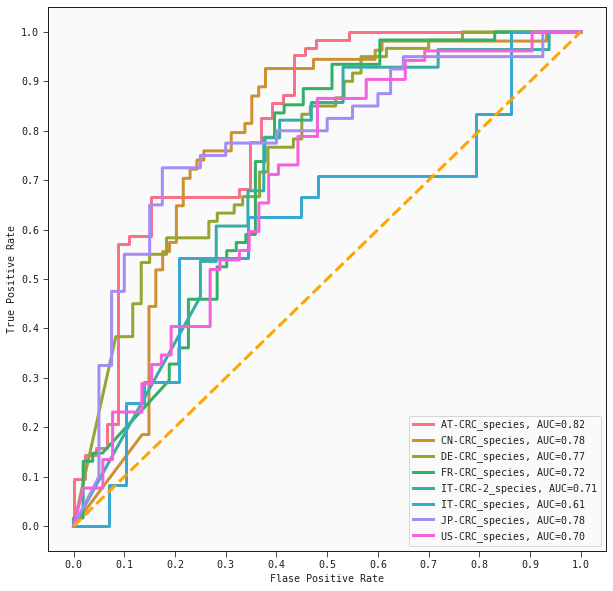

In [16]:
fig = plt.figure(figsize=(10,10))

for i in ROC_curve.index:
    plt.plot([float(s) for s in ROC_curve.loc[i]['fpr'].split(",")], 
             [float(s) for s in ROC_curve.loc[i]['tpr'].split(",")], 
             label="{}, AUC={:.2f}".format(i, ROC_curve.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate")#, fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate")#, fontsize=15)

plt.legend(prop={'size':10}, loc='lower right')
plt.savefig("plots/LOSO_FEYN_2.jpg")
plt.show()